# Goal

### Build a web scraper to gather data on used cars.

# Step 1 Identify Cars/Listings to Use 

### I used the top 10 car manufacturers to keep data managable and identified the top 10 car manufacters for 2023 using this website.
https://www.statista.com/statistics/264362/leading-car-brands-in-the-us-based-on-vehicle-sales/ 

# Step 2 Identify the details of listings i want to scrape

### I used the Inspector tool to locate the 'div' elements with the class 'vehicle-card' that contain the car listing details, allowing me to accurately extract and parse the data using BeautifulSoup in my web scraper.
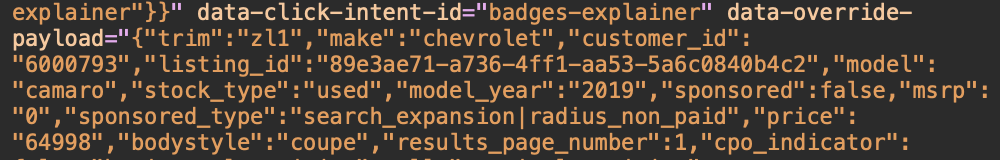
#### Car listing details used: 'listing_id', 'trim',  'make', 'year', 'model', 'price', 'body_style', 'city', 'state', 'mileage', 'stock_type'

# Step 3 Use BeautifulSoup to build webscraper 

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import time

# Base URL and headers for the request
url_template = "https://www.cars.com/shopping/results/?clean_title=true&dealer_id=&keyword=&list_price_max=&list_price_min=&makes[]=chevrolet&maximum_distance=all&mileage_max=&monthly_payment=&page={}&page_size=100&sort=best_match_desc&stock_type=used&year_max=2024&year_min=2010&zip=95207"
headers = {'User-Agent': 'Safari/537.3'}

# Define the columns for the DataFrame
df_columns = ['Listing ID', 'Trim', 'Make', 'Year', 'Model', 'Price', 'Body Style', 'City', 'State', 'Mileage', 'Stock Type']

# Scrape pages function
def scrape_pages(scrape_all_pages=False, max_pages=1000):
    start_time = time.time()  # Start timer
    page_number = 1
    listings_collected = set()
    rows_list = []  # List to collect each row dictionary

    while True:
        print(f"Scraping page: {page_number}") #prints each page scraped to verify its still running
        url = url_template.format(page_number)
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')

        vehicle_cards = soup.find_all('div', class_='vehicle-card')

        # Check if there are vehicle cards on the page or if the maximum page limit has been reached
        if not vehicle_cards or (not scrape_all_pages and page_number > max_pages):
            break

        for card in vehicle_cards:
            a_element = card.find('a', {'class': 'sds-link'})
            if a_element and 'data-override-payload' in a_element.attrs:
                payload = a_element['data-override-payload']
                payload_dict = json.loads(payload)

                # Check for duplicates using 'listing_id'
                listing_id = payload_dict.get('listing_id')
                if listing_id in listings_collected:
                    continue
                listings_collected.add(listing_id)

                city_state_text = card.select_one('div[data-qa="miles-from-user"]')
                city, state = (None, None)
                if city_state_text:
                    location_parts = city_state_text.get_text(strip=True).split(',')
                    if len(location_parts) >= 2:
                        city = location_parts[0].strip()
                        state = location_parts[1].split(' ')[1].strip()

                mileage_text = card.find('div', {'data_qa': 'mileage'})
                mileage = None
                if mileage_text:
                    mileage = mileage_text.get_text(strip=True).replace(' mi.', '').replace(',', '')

                # Extract details and add to the list of rows
                rows_list.append({
                    'Listing ID': listing_id,
                    'Trim': payload_dict.get('trim'),
                    'Make': payload_dict.get('make'),
                    'Year': payload_dict.get('model_year'),
                    'Model': payload_dict.get('model'),
                    'Price': payload_dict.get('price'),
                    'Body Style': payload_dict.get('bodystyle'),
                    'City': city,
                    'State': state,
                    'Mileage': mileage,
                    'Stock Type': payload_dict.get('stock_type', 'Not Specified')
                })

        # Increment the page number and wait before making the next request
        page_number += 1
        time.sleep(.5)  # Sleep for 1 second between requests

    # Create a DataFrame from the list of rows
    df = pd.DataFrame(rows_list, columns=df_columns)
    end_time = time.time()  # End timer
    print(f"Scraping completed in {end_time - start_time:.2f} seconds.")
    return df

# Scrape the first 1000 pages or all pages
df_1000_pages = scrape_pages()

# Save the DataFrame to a CSV file
df_1000_pages.to_csv('Chevrolet_Scrape_1000_pages.csv', index=False)

print('Chevrolet 1000 page scrape completed March 11th.')

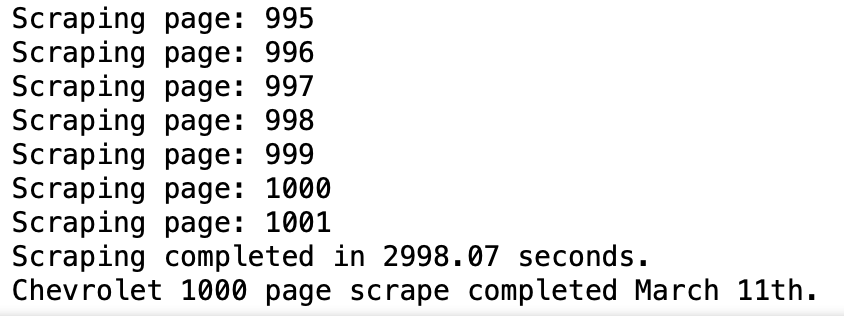

## Web Scraper details

#### -Made a web scraper for each make by changing url
#### -For url went to cars.com, filtered make, page size=100(listings), stock type=used, years 2010-2024
#### -Used listing id to minimize duplicate listings
#### -Added a timer in between page requests

# Results 

## CSV file of Chevrolet Scrape

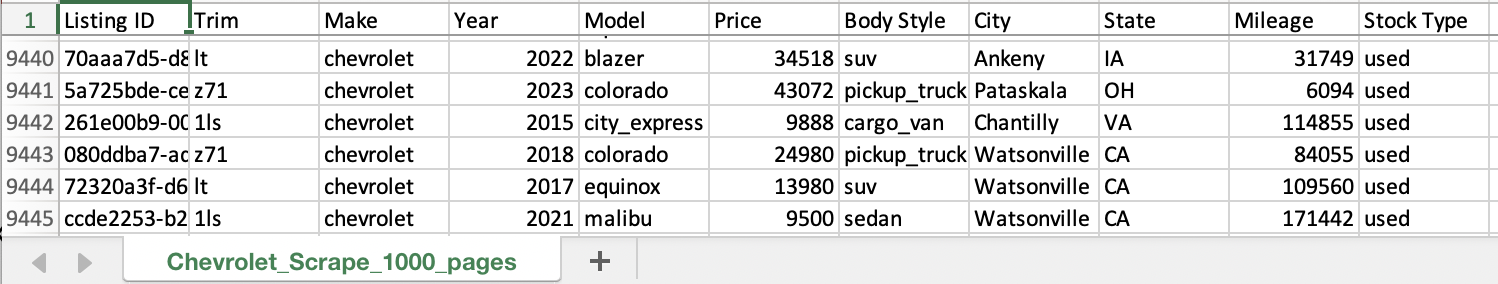



### Each scrape resulted in about 9,200-9,500 rows of listings and took about 60 minutes to complete.

## CSV after Combining all 10 Car Makes

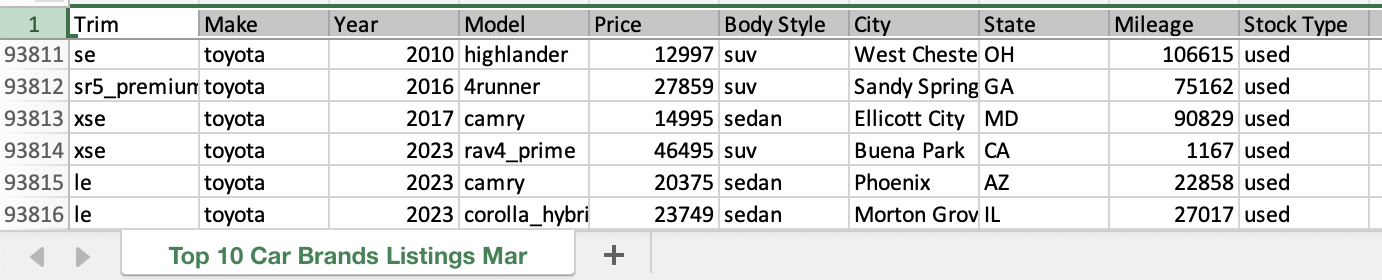

### After running the scraper on all 10 makes, i combined the CSV's. Then i checked for duplicate listings, only found 64, and I deleted them. 

## The final results was over 93,000 rows of used car listings from the top 10 Car Brands on Cars.com from March 11-12, 2024. 